An example for finding raw data which can be interpolated onto a specific LST range.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
from scipy.interpolate import CubicSpline
from astropy import units as u, constants as c
import pandas as pd
import os
from astropy.coordinates import Angle

In [2]:
def plot_raw_interp(data_raw, flags_raw, data_interp, flags_interp):
    
    finite = np.isfinite(data_raw/~flags_raw)
    
    vmin_r = np.nanmin(data_raw.real[finite])
    vmax_r = np.nanmax(data_raw.real[finite])
    vmin_i = np.nanmin(data_raw.imag[finite])
    vmax_i = np.nanmax(data_raw.imag[finite])
    
    print(vmin_r, vmax_r, vmin_i, vmax_i)
    
    plt.figure(figsize=(12,8))
    plt.subplot(2,2,1)
    plt.imshow(data_raw.real/~flags_raw, aspect='auto', vmin=vmin_r, vmax=vmax_r)
    plt.colorbar()
    plt.subplot(2,2,2)
    plt.imshow(data_raw.imag/~flags_raw, aspect='auto', vmin=vmin_i, vmax=vmax_i)
    plt.colorbar()
    plt.subplot(2,2,3)
    plt.imshow(data_interp.real/~flags_interp, aspect='auto', vmin=vmin_r, vmax=vmax_r)
    plt.colorbar()
    plt.subplot(2,2,4)
    plt.imshow(data_interp.imag/~flags_interp, aspect='auto', vmin=vmin_i, vmax=vmax_i)
    plt.colorbar()
    plt.show()

In [3]:
def jd_at_lst(uvdata, lst0):
    """ Given a UVData object, find the JD corresponding to the requested LST.  
    Uses simple linear interpolation. """
    jd = np.unique(uvdata.time_array)
    lst = np.unique(uvdata.lst_array)
    
    return np.interp(lst0, lst, jd)

In [4]:
# OK, this is going to be painful.  Build a new UVData object.
# The required attributes are a method

def BuildNewUVData(uvd_raw, lsts_new):
    
    Ntimes = len(lsts_new)

    # I hope linear interpolation is sufficiently accurate.
    jds_new = jd_at_lst(uvd_raw, lsts_new) 
    
    lsts = np.unique(uvd_raw.lst_array) # For some God-forsaken reason, LSTs are in radians
    # We're going to need the nearest index to the original JDs 
    jds = np.unique(uvd_raw.time_array)
    jd_nearest_indx = np.zeros_like(jds_new, dtype='int64')
    for i,jd in enumerate(jds_new):
        jd_nearest_indx[i] = np.argmin(np.abs(jds-jd))
    
    # Build up the list of required attributes
    attributes = list(uvd_raw.__dict__.keys())
    for i,attribute in enumerate(attributes):
        if attribute[0] == '_':
            attributes[i] = attribute[1:]
            
     # Define new array dimensions
    Nbls = uvd_raw.Nbls
    Nblts = Ntimes * Nbls
    Nspws = uvd_raw.Nspws
    Nfreqs = uvd_raw.Nfreqs
    Npols = uvd_raw.Npols   
    
    # Define new arrays
    data_array_new = np.zeros_like(uvd_raw.data_array, shape = [Nblts, Nspws, Nfreqs, Npols])
    flag_array_new = np.zeros_like(uvd_raw.flag_array, shape = [Nblts, Nspws, Nfreqs, Npols])
    nsample_array_new = np.ones_like(uvd_raw.nsample_array, shape = [Nblts, Nspws, Nfreqs, Npols])
    uvw_array_new = np.zeros_like(uvd_raw.uvw_array, shape=[Nblts, 3])
    time_array_new = np.zeros_like(uvd_raw.time_array, shape=[Nblts])
    lst_array_new = np.zeros_like(uvd_raw.lst_array, shape=[Nblts])
    ant_1_array_new = np.zeros_like(uvd_raw.ant_1_array, shape=[Nblts])
    ant_2_array_new = np.zeros_like(uvd_raw.ant_2_array, shape=[Nblts])
    baseline_array_new = np.zeros_like(uvd_raw.baseline_array, shape=[Nblts])
    integration_time_new = np.zeros_like(uvd_raw.integration_time, shape=[Nblts])
    
    # Copy over
    for itime in np.arange(Ntimes):
        for ibl in np.arange(Nbls):
            indx = itime * Nbls + ibl
            # If in drift mode, they're all the same
            uvw_array_new[indx, :] = uvd_raw.uvw_array[0, :]
            time_array_new[indx] = jds_new[itime]
            lst_array_new[indx] = lsts_new[itime]
            # we're really assuming the pattern repeats every time sample ...
            ant_1_array_new[indx] = uvd_raw.ant_1_array[ibl]
            ant_2_array_new[indx] = uvd_raw.ant_2_array[ibl]  
            
    # What do we need to change?
    to_change = {'Ntimes' : Ntimes,
                 'Nblts' : Nblts,
                 'data_array' : data_array_new,
                 'flag_array' : flag_array_new, # ... hoo boy
                 'nsample_array' : nsample_array_new, # what?
                 'uvw_array' : uvw_array_new, #... need to confirm we're drift scanning
                 'time_array' : time_array_new, 
                 'lst_array' : lst_array_new, 
                 'integration_time' : integration_time_new,
                 'ant_1_array' : ant_1_array_new, # why God, why?
                 'ant_2_array' : ant_2_array_new,
                 'baseline_array' : baseline_array_new # Oh, fuck my life
                }
    
    # Define the new object
    uvd_new = UVData()

    for attribute in attributes:
        if attribute in to_change.keys():
            #print('Changing '+attribute)
            setattr(uvd_new, attribute, to_change[attribute])
        else:
            #print('Keeping '+attribute)
            setattr(uvd_new, attribute, getattr(uvd_raw, attribute))
        try:
            blt_ind1, blt_ind2, pol_ind = uvd_new._key2inds(bl)
            #print('blt_ind1', blt_ind1.shape)
        except:
            pass
            #print('Cannot get key2ind')
    
    # Hopefully robust
    uvd_new.integration_time[:] = uvd_new._calc_single_integration_time()
    
    # Don't know how to generate these magic nubmers otherwise
    uvd_new.baseline_array = uvd_new.antnums_to_baseline(uvd_new.ant_1_array, uvd_new.ant_2_array)
    
    # Some checking
    assert uvd_new.Nants_data == uvd_raw.Nants_data
    
    # OK, now go through baseline by baseline to fix up the changed data ..
    for bl in uvd_new.get_antpairpols()[0:9]:
        print(bl)
        data = uvd_raw.get_data(bl)
        # There might not be a good way to handle flagging that differs in time between frequencies ...
        # i.e., I think when the size of the unflagged data differs, you might just have to loop.  Ugh.
        # And then, if there is no good data ... double Ugh.
        flags = uvd_raw.get_flags(bl)
        data_interp = np.zeros_like(data, shape=[uvd_new.Ntimes, uvd_new.Nfreqs])
        flags_interp = np.zeros_like(flags, shape=[uvd_new.Ntimes, uvd_new.Nfreqs])
    
        for ifreq in np.arange(uvd_new.Nfreqs):
            fflags = ~flags[:,ifreq].squeeze()
            flags_interp[:, ifreq] = flags[jd_nearest_indx, ifreq]
            # If there is not enough data to spline interpolate, skip
            if fflags.sum() >= 2:
                cs = CubicSpline(lsts[fflags], data[fflags, ifreq])
                data_interp[:, ifreq] = cs(lsts_new)
              
                # This was super clever for vectorizing the cubic spline across frequencies, but I don't think
                # it generalizes with different flags for every frequency
                #cs = CubicSpline(lsts, data, axis=0)
                #interp = cs(lsts_new)
    
        # Need that magic incantation for shoving a visibility's data back into the UVData object
        inds = uvd_new._key2inds(bl)
        blt_inds = inds[0]
        pol_ind = inds[2][0]
        uvd_new.data_array[blt_inds,0,:,pol_ind] = data_interp
        uvd_new.flag_array[blt_inds,0,:,pol_ind] = flags_interp
    
    return uvd_new

Define the LST grid.

In [5]:
# Set up LST grid; in radians
# A trifle worried about numerical precision, but let's plunge ahead

# Files will be this long
lst_bin_size = 6.*u.min
n_lst_bins = int((24.*u.hr/lst_bin_size).to(u.dimensionless_unscaled).value)
lst_edges = np.linspace(0, 2.*np.pi, n_lst_bins+1, endpoint=True)
lst_start = lst_edges[0:-1]
lst_end = lst_edges[1:]
lst_mid = (lst_start + lst_end)/2.

assert len(lst_start) == n_lst_bins
assert len(lst_end) == n_lst_bins
assert np.isclose((lst_end-lst_start)*24.*60./(2.*np.pi), lst_bin_size.value).sum() == n_lst_bins

# Need to specify the time sampling within a "bin"
lst_time_sample = 10*u.s # This is actually every 10 sidereal seconds
n_samples = int((lst_bin_size/lst_time_sample).to(u.dimensionless_unscaled).value)
lst_sampling = ((np.arange(n_samples)*lst_time_sample)/(24*u.hr)).to(u.dimensionless_unscaled).value*2.*np.pi

pad = 40/3600.*2.*np.pi/24.

In [6]:
JD = '2457548'
rawpath = '/lustre/aoc/projects/hera/jaguirre/HERA19Summer2020/RawData/'+JD+'/'

In [7]:
# Grab the summary file for the day in question
summary = pd.read_csv(os.path.join(rawpath,JD+'_summary.csv'))
filenames_all = np.array(summary['Filename'])
lsts_all = np.array(summary['LST (rad)'])
jds_all = np.array(summary['Julian Date'])

In [8]:
%%time

# Probably want to calculate how many time samples *should* appear ...
min_time_samp = 1
for i in np.arange(120,121):#n_lst_bins):
    
    # We're going to pick this LST bin
    lst_min = lst_start[i]
    lst_max = lst_end[i]
    lsts_new = lst_min + lst_sampling

    lst_range = np.logical_and(lsts_all >= lst_min-pad, lsts_all < lst_max+pad)

    if lst_range.sum() > min_time_samp:

        # Output filename
        lst_min_str = Angle(lst_min, u.rad).to_string(unit=u.hr)
        lst_max_str = Angle(lst_max-lst_sampling[1], u.rad).to_string(unit=u.hr)
        lst_filename = 'lst.'+JD+'.'+lst_min_str+'.'+lst_max_str+'.uvcRP.drift.uvh5'

        files_to_read = rawpath+np.unique(filenames_all[lst_range])
        uvd_raw = UVData()
        uvd_raw.read(files_to_read, time_range=[jds_all[lst_range].min(), jds_all[lst_range].max()])

        uvd_new = BuildNewUVData(uvd_raw, lsts_new)

        # uvd_new.write_uvh5(os.path.join(path, lst_filename), clobber=True)

(9, 9, 'xx')
(9, 9, 'yy')
(9, 9, 'xy')
(9, 9, 'yx')
(9, 10, 'xx')
(9, 10, 'yy')
(9, 10, 'xy')
(9, 10, 'yx')
(9, 20, 'xx')
CPU times: user 4.92 s, sys: 1.14 s, total: 6.05 s
Wall time: 7.64 s


-0.5130405426025391 0.6246471405029297 -0.7546386122703552 0.40140438079833984


divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


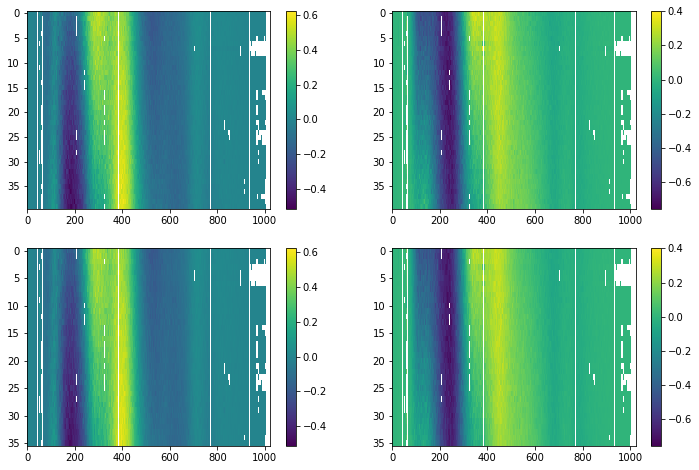

In [9]:
bl = (9,20,'xx')
#uvd_raw_t = uvd_raw.select(bls=bl, time_range=[jds_new.min(), jds_new.max()], inplace=False)
data = uvd_raw.get_data(bl)
flags = uvd_raw.get_flags(bl)
data_interp = uvd_new.get_data(bl)
flags_interp = uvd_new.get_flags(bl)

plot_raw_interp(data, flags, data_interp, flags_interp)

In [10]:
uvd_new.check(check_extra=True, run_check_acceptability=True, check_freq_spacing=True)

ValueError: Some cross-correlations have near-zero uvw_array magnitudes.

In [ ]:
uvd_raw.antenna_numbers

In [ ]:
uvd_new.antenna_numbers.shape